# Generate Causal Bar Color MNIST

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import seaborn as sns
import torch
import torchvision
import torchvision.datasets.utils as dataset_utils
import torchvision.transforms.functional as F
from PIL import Image
from scipy import stats
from scipy.stats import truncnorm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import MultiDistrDataModule
from gendis.datasets.causalbarmnist import (
    CausalBarMNIST,
    SingleDigitDataset,
    bar_scm,
    create_altered_mnist_dataset,
)
from gendis.datasets.morphomnist import morpho, perturb
from gendis.datasets.utils import show_imgs

plt.rcParams["savefig.bbox"] = "tight"
import numpy as np
import seaborn as sns

In [3]:
root = Path("/Users/adam2392/pytorch_data/")

In [4]:
def add_bar(
    idx, bar, mnist, bar_val=255, start_height=0, height=4, start_width=0, width=None
):
    img = mnist[idx].clone().numpy().reshape(28, 28, 1)

    if width is None:
        width = img.shape[1]

    # add bar
    if bar == 1:
        img[
            start_height : start_height + height, start_width : start_width + width, -1
        ] = bar_val
    return img


def get_mnist_digit(images, labels, target):
    raw_images = []
    for image, label in zip(images, labels):
        if label == target:
            raw_images.append(image)
    return raw_images


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        # img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
import normflows as nf
import torchvision
from torchvision.datasets.mnist import MNIST

root = "/Users/adam2392/pytorch_data/"

# set up transforms for each image to augment the dataset
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        nf.utils.Jitter(1 / 256.0),  # apply random generation
        torchvision.transforms.RandomRotation(350),  # get random rotations
    ]
)

mnist_data = MNIST(root, train=True, download=True, transform=transform)

images = mnist_data.data
labels = mnist_data.targets

images = get_mnist_digit(images, labels, 0)
print(len(images))

5923


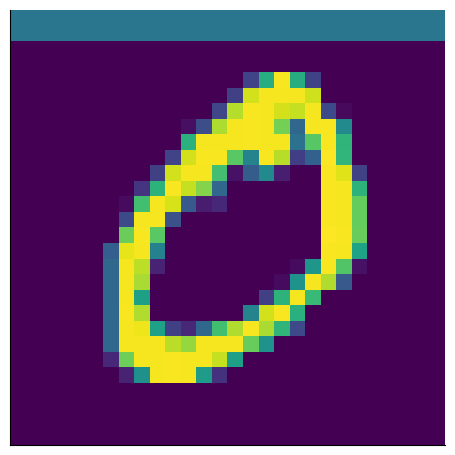

In [5]:
new_img = add_bar(0, 1, images, bar_val=100, height=2, start_height=0)


show([new_img])

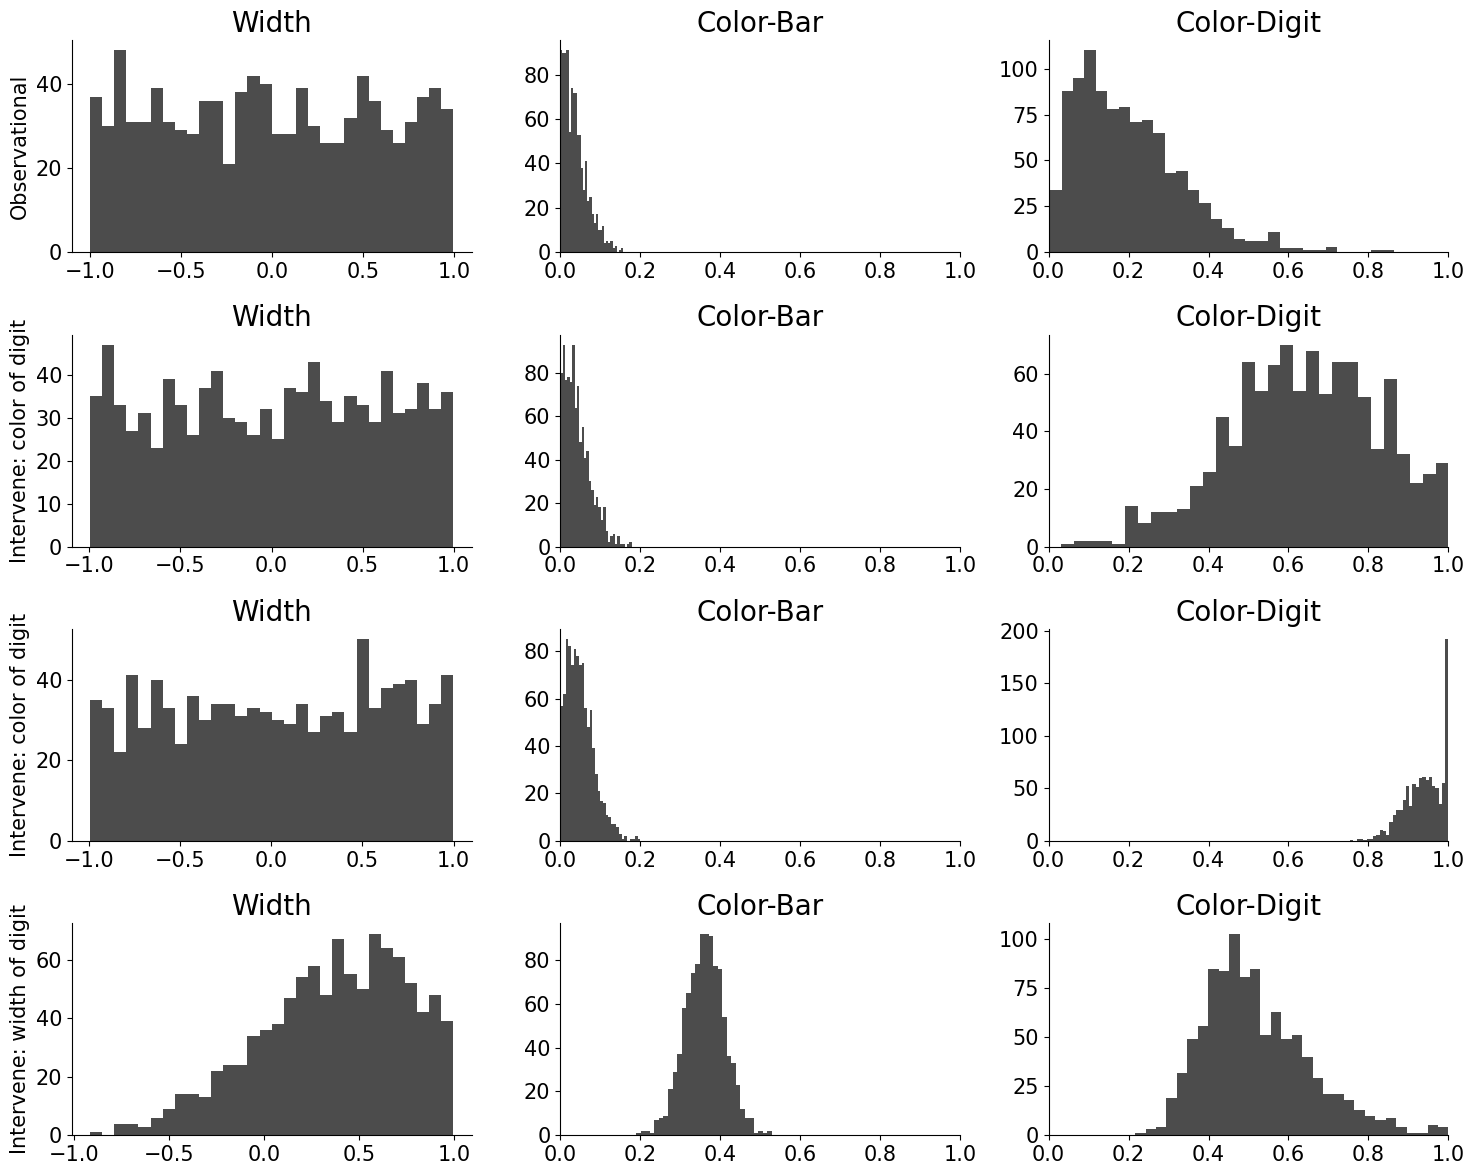

In [136]:
# Plotting the distributions
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=False, sharey=False)

for idx in range(4):
    meta_labels, width, color_bar, color_digit = bar_scm(
        n_samples=1000, intervention_idx=idx, label=0
    )
    if idx == 0:
        setting = "Observational"
    elif idx == 1:
        setting = "Intervene: color of digit"
    elif idx == 2:
        setting = "Intervene: color of digit"
    elif idx == 3:
        setting = "Intervene: width of digit"
    axes[idx, 0].set_ylabel(f"{setting}")

    axes[idx, 0].hist(width, bins=30, color="black", alpha=0.7)
    axes[idx, 0].set_title(f"Width")
    axes[idx, 1].hist(color_bar, bins=30, color="black", alpha=0.7)
    axes[idx, 1].set_title(f"Color-Bar")
    axes[idx, 1].set_xlim([0, 1])
    axes[idx, 2].hist(color_digit, bins=30, color="black", alpha=0.7)
    axes[idx, 2].set_title(f"Color-Digit")
    axes[idx, 2].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Generate dataset

In [5]:
print(root)

/Users/adam2392/pytorch_data


In [33]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(
    root=root,
    train=True,
    download=True,  # transform=transform
)
digit = 0
n_jobs = 4

digit_zero_dataset = SingleDigitDataset(mnist_dataset, digit=digit)
mnist_loader = DataLoader(digit_zero_dataset, batch_size=1, shuffle=True)

In [34]:
all_imgs = []
all_labels = []
n_samples = 10

for intervention_idx in [0, 1, 2, 3]:
    imgs, labels = create_altered_mnist_dataset(
        mnist_loader,
        label=digit,
        n_samples=n_samples,
        intervention_idx=intervention_idx,
        n_jobs=n_jobs,
    )

    all_imgs.extend(imgs)

    for label in labels:
        label["distr_idx"] = intervention_idx
    all_labels.extend(labels)

(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)
(28, 28, 3)


In [27]:
keys = ["width", "color_digit", "color_bar", "label", "distr_idx"]

label_tensor = torch.zeros((len(all_labels), len(keys)))
# convert the labels from a list of dictionaries to a tensor array
for idx, key in enumerate(keys):
    label_tensor[:, idx] = torch.Tensor([label[key] for label in all_labels])

intervention_target_tensor = torch.zeros((len(all_labels), 3), dtype=torch.int)
intervention_target_tensor[:] = torch.Tensor(
    [label["intervention_targets"] for label in all_labels]
)

In [29]:
# save the actual data to disc now
imgs_fname = root / "CausalBarMNIST" / "chain" / "chain-imgs-train.pt"
labels_fname = root / "CausalBarMNIST" / "chain" / "chain-labels-train.pt"
targets_fname = root / "CausalBarMNIST" / "chain" / "chain-targets-train.pt"
imgs_fname.parent.mkdir(exist_ok=True, parents=True)

torch.save(all_imgs, imgs_fname)
torch.save(label_tensor, labels_fname)
torch.save(intervention_target_tensor, targets_fname)

In [173]:
all_imgs = torch.stack(all_imgs)
all_imgs /= 255
# print(imgs[0][0, 0, 0], imgs[0][1, 0, 0], imgs[0][2, 0, 0])

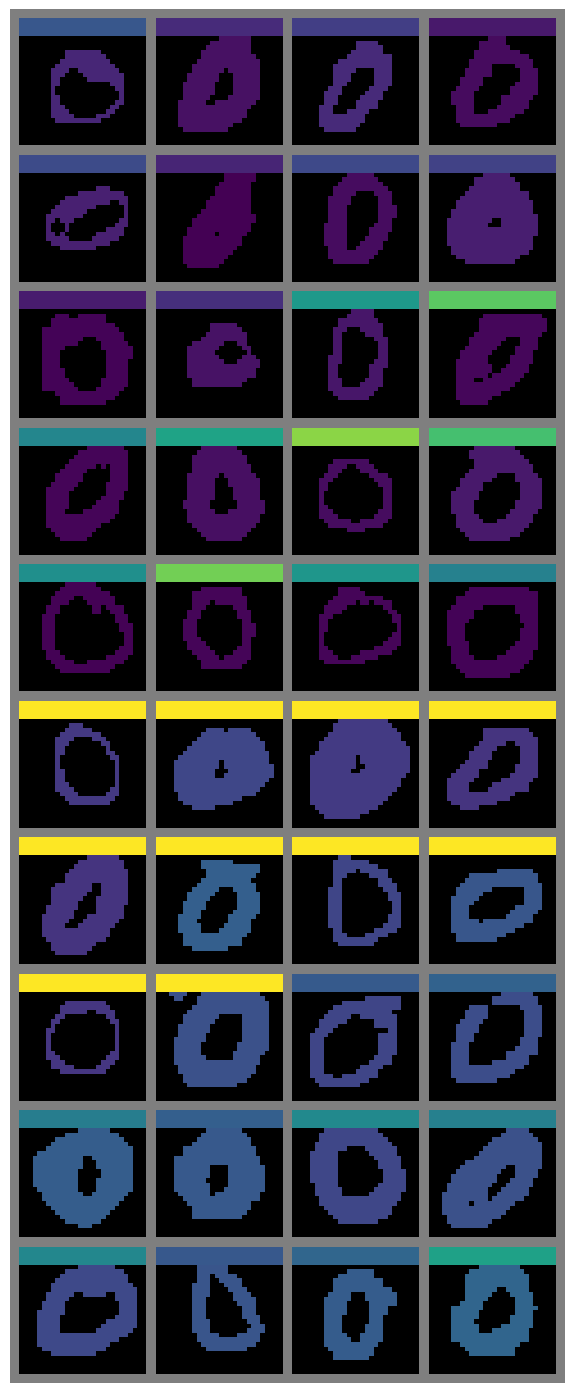

In [174]:
show_imgs(all_imgs)

In [175]:
pprint(all_labels[0])
print(all_labels[-1])

{'color_bar': tensor(0.1055),
 'color_digit': tensor(0.2721),
 'distr_idx': 0,
 'intervention_targets': [0, 0, 0],
 'label': 0,
 'width': tensor(-0.7506)}
{'width': tensor(0.2034), 'color_digit': tensor(0.5732), 'color_bar': tensor(0.3251), 'label': 0, 'intervention_targets': [1, 0, 0], 'distr_idx': 3}


# Inspect random samples from the dataset

Here, we can reload the dataset that was saved to disc and inspect what a random batch would look like.

In [30]:
graph_type = "chain"

dataset = CausalBarMNIST(
    root=root, graph_type=graph_type, transform=transform, n_jobs=1
)

In [25]:
batch_size = 32
graph_type = "chain"

transform = transforms.Compose([transforms.ToTensor()])

data_module = MultiDistrDataModule(
    root=root,
    graph_type=graph_type,
    batch_size=batch_size,
    stratify_distrs=True,
    transform=transform,
    num_workers=1,
)
data_module.setup()

36000
3


In [27]:
dataiter = iter(data_module.train_dataloader())
images, labels, targets = next(dataiter)

print(images.shape, labels.shape, targets.shape)

torch.Size([32, 3, 28, 28]) torch.Size([32, 5]) torch.Size([32, 3])


In [30]:
print(labels[:, -1])

tensor([2., 3., 3., 1., 1., 0., 0., 3., 3., 2., 3., 1., 1., 1., 3., 2., 1., 1.,
        2., 1., 3., 2., 0., 2., 0., 0., 0., 2., 0., 0., 2., 3.])


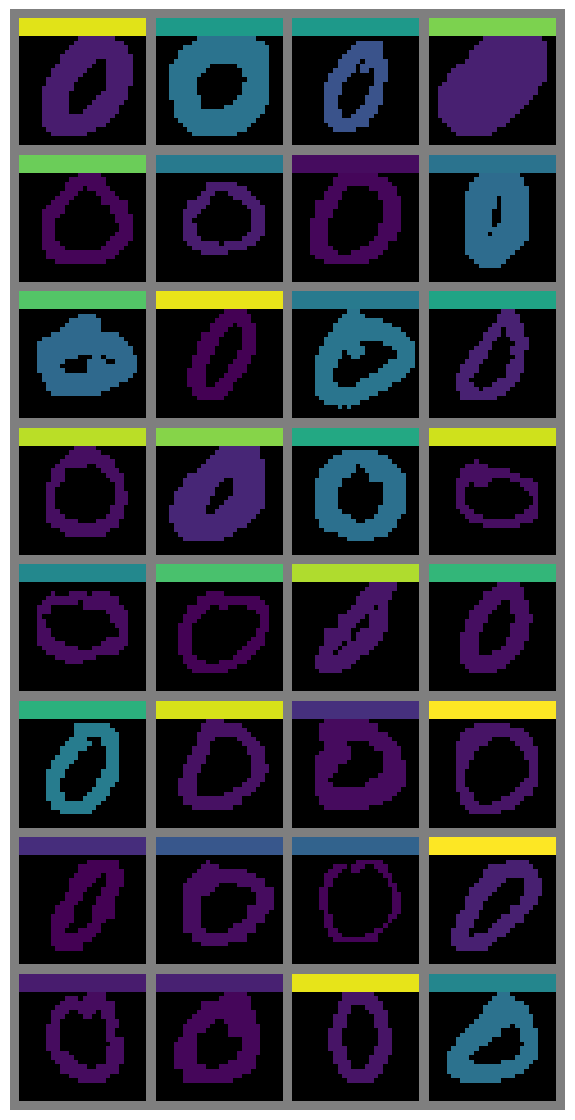

In [31]:
show_imgs(images)